<h1>Композиция методов. Бустинг

In [1]:
import pandas as pd
import numpy as np
import random
import warnings
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split,learning_curve
from sklearn import metrics, ensemble
import matplotlib.pyplot as plt
import statistics
from sklearn.metrics import confusion_matrix

In [2]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

<h2>Boosting

Одна из самых популярных библиотек при работе с бустингом -- xgboost. Он реализует алгоритм градиентного бустинга в довольно общем виде. 

Рассмотрим параметры XGboost. Выделяют три группы параметров:
* Общие параметры, отвечающие за базовый алгоритм для бустинга и распараллеливание.
* Параметры выбранного базового алгоритма.
* Параметры обучения, отвечающие за функцию потерь и метрику качества на валидации.

<h4>Общие параметры:</h4>

* booster - тип базового алгоритма для бустинга: дерево решений gbtree или линейная модель gblinear, dart.
* silent(/verbosity)  - выдавать (silent=0) или нет (silent=1) сообщения по ходу работы алгоритма. (Valid values are 0 (silent) - 3 (debug).)
* nthread (/n_jobs)- число нитей доступных для параллельной работы xgboost.

<h4>Параметры базового алгоритма:</h4>

<h5>Дерево решений:</h5>

* eta (/learning_rate) - темп обучения, перед добавлением дерева в композицию оно умножается на eta. Используется для предотвращения переобучения за счёт "сокращения" весов базовых алгоритмов, делая модель более консервативной. Чем меньше eta, тем больше нужно итераций num_boost_round для обучения модели с хорошим качеством. Диапазон: $[0, 1]$
* gamma - минимальное снижение значения функции потерь, необходимое для дальнейшего разбиения вершины дерева. Большие значения gamma > 0 приводят к более консервативным моделям. Диапазон: $[0, \infty)$.
* max_depth - максимальная глубина дерева. Диапазон: [1, $\infty$).
* min_child_weight - минимальное необходимое (взвешенное) число примеров в каждой вершине. Чем больше, тем более консервативна итоговая модель. Диапазон: $[0, \infty)$.
* max_delta_step - обычно равен нулю. Положительные значения используются при несбалансированных классах для ускорения сходимости. Диапазон $[0, \infty)$.
* subsample - доля выборки, используемая для обучения каждого дерева. Если subsample < 1, то выбирается случайная подвыборка, что помогает в борьбе с переобучением. Диапазон: $(0, 1]$
* colsample_bytree - доля признаков, используемая для обучения каждого дерева. Диапазон: $(0, 1]$
* lambda (/reg_lambda) - коэффициент перед $L_2$-регуляризатором в функции потерь.
* alpha (/reg_alpha) - коэффициент перед $L_1$-регуляризатором в функции потерь.

<h5>Линейная модель:</h5>
* lambda - коэффициент перед $L_2$-регуляризатором вектора весов в функции потерь.
* alpha  - коэффициент перед $L_1$-регуляризатором вектора весов в функции потерь.
* lambda_bias - коэффициент перед $L_2$-регуляризатором смещения (свободного члена) в функции потерь.

<h4>Параметры задачи обучения:</h4>

* objective - используемая при обучении функция потерь:

"reg:linear" – линейная регрессия.
"reg:logistic" – логистическая регрессия.
"binary:logistic" – логистическая регрессия для бинарной классификации, на выходе - вероятность.
"binary:logitraw" – то же самое, но на выходе - значение до его преобразования логистической функцией.
"count:poisson" – регрессия Пуассона (используется для оценки числа каких-то событий, счётный признак), на выходе - матожидания распределения Пуассона. В этом случае max_delta_step автоматически устанавливается равным 0.7.
"multi:softmax" – обобщение логистической регрессии на многоклассовый случай. При этом нужно задать параметр num_class.
"multi:softprob" – то же самое, но на выходе - вектор размера ndata * nclass, который можно преобразовать в матрицу, содержащую вероятности отнесения данного объекта к данному классу.
"rank:pairwise" – используется для задач ранжирования.

* base_score [default=0.5] - инициализация значения модели для всех примеров, глобальное смещение.
* eval_metric [default according to objective] - метрика качества на валидационной выборке (по умолчанию соответствует функции потерь: rmse - для регрессии, error - для классификации, mean average precision - для ранжирования). Выбрать можно одну из следующих метрик:
"rmse": root mean square error.
"logloss": минус логарифм правдоподобия.
"error": доля ошибок для бинарной классификации.
"merror": то же самое для многоклассовой классификации.
"mlogloss": logloss для многоклассовой классификации.
"auc": AUC.
"ndcg": Normalized Discounted Cumulative Gain.
"map": Mean average precision.
"ndcg@n",”map@n”: здесь n - целое число, первые n позиций в списке не учитываются.
"ndcg-",”map-”,”ndcg@n-”,”map@n-”: списку из всех положительных примеров будет присвоено значение 0 (вместо 1).
* seed (/random_state) - для воспроизводимости "случайности".


Эти параметры используются при вызове, например, методов XGBClassifier() и XGBRegressor().  

Иногда удобнее использовать метод train (xgboost.train), так как он имеет некоторые дополнительные возможности. (Например, тут можно вводить произвольную функцию потерь и функцию оценки качества).

<h4>Параметры в xgboost.train:</h4>

* params (dict) – параметры, описанные выше.
* dtrain (DMatrix) – обучающая выборка.
* num_boost_round (int) – число итераций бустинга.
* evals (list) – список для оценки качества во время обучения.
* obj (function) – собственная функция потерь.
* feval (function) – собственная функция для оценки качества.
* maximize (bool) – нужно ли максимизировать feval.
* early_stopping_rounds (int) – активирует early stopping. Ошибка на валидации должна уменьшаться каждые early_stopping_rounds итераций для продолжения обучения. Список evals должен быть не пуст. Возвращается модель с последней итерации. Если произошел ранний останов, то модель будет содержать поля: bst.best_score и bst.best_iteration.
* evals_result (dict) – результаты оценки качества.
* verbose_eval (bool) – вывод значения метрики качества на каждой итерации бустинга.
* learning_rates (list or function) – коэффициент скорости обучения для каждой итерации - list l: eta = l[boosting round] - function f: eta = f(boosting round, num_boost_round).
* xgb_model (file name of stored xgb model or ‘Booster’ instance) – возможность продолжить обучения имеющейся модели XGB.

Note that XGBoost does not provide specialization for categorical features; if your data contains categorical features, load it as a NumPy array first and then perform one-hot encoding.

<h2>Регрессия

In [30]:
df.shape

(20640, 8)

In [37]:
import math
from sklearn import preprocessing
house=pd.read_csv('housing.csv')
df=house.drop('ocean_proximity',axis=1)
df=df.drop('total_bedrooms',axis=1)
df.head()


,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0


In [38]:
df = preprocessing.scale(df)
df = preprocessing.normalize(df)
df=pd.DataFrame(df,columns=['longitude','latitude','housing_median_age','total_rooms','population','households','median_income','median_house_value'])
df.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value
0,-0.327679,0.259744,0.242370,-0.198611,-0.240466,-0.241109,0.578634,0.525543
1,-0.311025,0.245272,-0.142721,0.481027,0.202540,0.392639,0.548353,0.308983
2,-0.373485,0.291009,0.520139,-0.150127,-0.229998,-0.236404,0.499548,0.352711
3,-0.421867,0.327481,0.585327,-0.196839,-0.241559,-0.231390,0.294201,0.367402
4,-0.449030,0.348567,0.623015,-0.155203,-0.255038,-0.211173,-0.004323,0.393676


Итак, данные содержат 8 количественных переменных и 20640 наблюдений. Будем предсказывать среднюю стоимость дома.

Разобьем на тренировочную и тестовую выборки:

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('median_house_value', axis=1), df['median_house_value'],
                                                    test_size=0.3,random_state=17)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [7]:
params = {
    'objective':'reg:linear',
    'max_depth':3,
    'silent':1,
    'eta':0.5
}

num_rounds = 50

In [8]:
watchlist  = [(dtest,'test'), (dtrain,'train')]
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)


[0]	test-rmse:0.408757	train-rmse:0.406821
[1]	test-rmse:0.311944	train-rmse:0.310529
[2]	test-rmse:0.277269	train-rmse:0.273795
[3]	test-rmse:0.2594	train-rmse:0.255093
[4]	test-rmse:0.24196	train-rmse:0.238231
[5]	test-rmse:0.235528	train-rmse:0.230975
[6]	test-rmse:0.230175	train-rmse:0.225028
[7]	test-rmse:0.22548	train-rmse:0.219497
[8]	test-rmse:0.222659	train-rmse:0.216382
[9]	test-rmse:0.220054	train-rmse:0.213088
[10]	test-rmse:0.218365	train-rmse:0.211144
[11]	test-rmse:0.216398	train-rmse:0.208697
[12]	test-rmse:0.21474	train-rmse:0.206563
[13]	test-rmse:0.213086	train-rmse:0.204635
[14]	test-rmse:0.212154	train-rmse:0.203358
[15]	test-rmse:0.211266	train-rmse:0.202152
[16]	test-rmse:0.209297	train-rmse:0.200156
[17]	test-rmse:0.2078	train-rmse:0.198544
[18]	test-rmse:0.206969	train-rmse:0.197394
[19]	test-rmse:0.206233	train-rmse:0.196365
[20]	test-rmse:0.202175	train-rmse:0.192385
[21]	test-rmse:0.200897	train-rmse:0.19085
[22]	test-rmse:0.200333	train-rmse:0.189893
[23]	t

Важность признаков (вычисляется на основе того, как часто разбиение делалось по данному признаку):

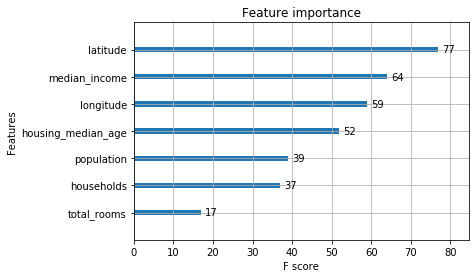

In [10]:
xgb.plot_importance(xgb_model)

Результат, корень MSE на тестовом множестве:

In [11]:
from sklearn.metrics import explained_variance_score
predictions = xgb_model.predict(dtest)
print("RMSE: %.2f"
      % math.sqrt(np.mean((predictions - y_test) ** 2)))
print(explained_variance_score(predictions,y_test))

RMSE: 0.19
0.641398140750655


Подберем гиперпараметры. Так как объем выборки уже довольно приличный -- сразу запустить грид по всем не выйдет -- умрем отстарости. Будем жадно подбирать параметры. Пусть деревьев будет 100 (опять же в силу вычислительной сложности).

In [12]:
params_rate = {
    'learning_rate': np.arange(0.01, 0.3, 0.01)
}

In [13]:
gsearch_rate = GridSearchCV(xgb.XGBRegressor(n_estimators=100,objective='reg:squarederror'),
                        param_grid = params_rate,n_jobs=4,iid=False, cv=3)
gsearch_rate.fit(X_train,y_train)
print(gsearch_rate.best_score_)
print(gsearch_rate.best_params_)

c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.7588111152118313
{'learning_rate': 0.29000000000000004}


Получили значение на конце, так что изменим границы.

In [14]:
params_rate = {
    'learning_rate': np.arange(0.3, 0.6, 0.05)
}
gsearch_rate = GridSearchCV(xgb.XGBRegressor(n_estimators=100,objective='reg:squarederror'),
                        param_grid = params_rate,n_jobs=4,iid=False, cv=3)
gsearch_rate.fit(X_train,y_train)
print(gsearch_rate.best_score_)
print(gsearch_rate.best_params_)

0.770100559082764
{'learning_rate': 0.44999999999999996}


Теперь сразу подбираем max_depth и min_child_weight:

In [15]:
param_test1 = {
 'max_depth':range(2,9,1),
 'min_child_weight':range(1,7,1)
}
gsearch_mm = GridSearchCV(xgb.XGBRegressor(n_estimators=100,objective='reg:squarederror',learning_rate=0.45),
                        param_grid = param_test1,n_jobs=4,iid=False, cv=3)
gsearch_mm.fit(X_train,y_train)
print(gsearch_mm.best_score_)
print(gsearch_mm.best_params_)

0.7874443371419155
{'max_depth': 7, 'min_child_weight': 5}


In [16]:
param_gamma = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch_gamma = GridSearchCV(xgb.XGBRegressor(n_estimators=100,objective='reg:squarederror',learning_rate=0.45,
                                           max_depth=7,min_child_weight=5),
                        param_grid = param_gamma,n_jobs=4,iid=False, cv=3)
gsearch_gamma.fit(X_train,y_train)
print(gsearch_gamma.best_score_)
print(gsearch_gamma.best_params_)

0.7874443371419155
{'gamma': 0.0}


In [17]:
param_reg = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch_reg = GridSearchCV(xgb.XGBRegressor(n_estimators=100,objective='reg:squarederror',learning_rate=0.45),
                        param_grid = param_reg,n_jobs=4,iid=False, cv=3)
gsearch_reg.fit(X_train,y_train)
print(gsearch_reg.best_score_)
print(gsearch_reg.best_params_)

0.7724761162962449
{'reg_alpha': 1, 'reg_lambda': 0.1}


Итоговая модель на тестовых данных:

In [18]:
#best_model = xgb.XGBRegressor(max_depth =7,min_child_weight=5,gamma=0, learning_rate=0.45,#то же самое, что и ниже
#                              n_estimators=100,objective='reg:squarederror',
#                               reg_alpha=1, reg_lambda=0.1)
#best_model.fit(X_train, y_train)
params_best={
    'max_depth':7,
    'min_child_weight':5,
    'gamma':0, 
    'learning_rate':0.45,              
    'objective':'reg:squarederror',                
    'reg_alpha':1, 
    'reg_lambda':0.1
}
watchlist  = [(dtest,'test'), (dtrain,'train')]
evals_result={}
best_model=xgb.train(params_best,dtrain, 100,watchlist,evals_result=evals_result,verbose_eval=0)

predictions  = best_model.predict(dtest)
print("test RMSE: %.2f"
      % math.sqrt(np.mean((predictions - y_test) ** 2)))
print(explained_variance_score(predictions,y_test))


test RMSE: 0.16
0.771391532148467


RMSE действительно стала меньше, хоть и не то чтобы очень сильно (было 0.19, стало 0.16).

Ошибка по итерациям:

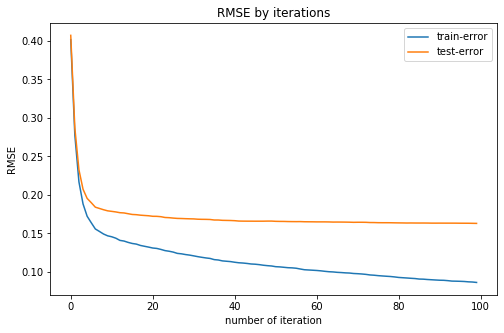

In [19]:
plt.figure(figsize=(8,5))
plt.plot(range(0,100),pd.DataFrame(evals_result['train']), label = "train-error")
plt.plot(range(0,100),pd.DataFrame(evals_result['test']), label = "test-error")
plt.xlabel("number of iteration")
plt.ylabel("RMSE")
plt.title("RMSE by iterations")
plt.legend()
plt.show()


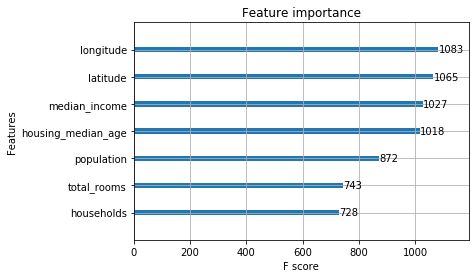

In [20]:
xgb.plot_importance(best_model)

Сравним с Random Forest:

In [21]:
rf = RandomForestRegressor(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=3)
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
print("test RMSE: %.4f"
      % math.sqrt(np.mean((y_pred_test - y_test) ** 2)))
print(explained_variance_score(y_pred_test,y_test))


test RMSE: 0.1658
0.70257329633782


Надо бы тоже параметры подобрать, а то нечестно...

In [22]:
param_test1 = {
   'min_samples_leaf':range(1,8,2),
   'min_samples_split':range(2,30,2)
}
gsearch_mm = GridSearchCV(RandomForestRegressor(n_estimators=100,
                               warm_start=True, oob_score=True,random_state=3, max_features="sqrt"),
                        param_grid = param_test1,n_jobs=4,iid=False, cv=3)
gsearch_mm.fit(X_train,y_train)
print(gsearch_mm.best_score_)
print(gsearch_mm.best_params_)

0.7912554235406484
{'min_samples_leaf': 1, 'min_samples_split': 4}


Итого:

In [24]:
rf = RandomForestRegressor(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=3,min_samples_leaf=1,min_samples_split=4)
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
print("Test RMSE: %.4f"
      % math.sqrt(np.mean((y_pred_test - y_test) ** 2)))
print(explained_variance_score(y_pred_test,y_test))

Test RMSE: 0.1661
0.6973524050023753


На самом деле rmse от этого особо и не уменьшилось. Тут скорее проблема в том, что 100 деревьев -- мало для Random Forest.

<h3> Парная регрессия</h3> 

Попробуем предсказать цену дома только по признаку 'median_income'.

In [8]:
df1=df[['median_income','median_house_value']]
df1.head()
X_train, X_test, y_train, y_test = train_test_split(df1.drop('median_house_value', axis=1), df1['median_house_value'],
                                                    test_size=0.3,random_state=17)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)


In [9]:
params = {
    'objective':'reg:linear',
    'max_depth':3,
    'silent':1,
    'eta':0.5
}
num_rounds = 50

In [27]:
watchlist  = [(dtest,'test'), (dtrain,'train')] 
ev={}
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist,evals_result=ev)

[0]	test-rmse:0.412905	train-rmse:0.411891
[1]	test-rmse:0.325669	train-rmse:0.325913
[2]	test-rmse:0.299795	train-rmse:0.300309
[3]	test-rmse:0.292937	train-rmse:0.293255
[4]	test-rmse:0.291245	train-rmse:0.291238
[5]	test-rmse:0.290838	train-rmse:0.290627
[6]	test-rmse:0.290747	train-rmse:0.290379
[7]	test-rmse:0.290976	train-rmse:0.290117
[8]	test-rmse:0.291025	train-rmse:0.289998
[9]	test-rmse:0.291061	train-rmse:0.289896
[10]	test-rmse:0.291086	train-rmse:0.289829
[11]	test-rmse:0.291083	train-rmse:0.289752
[12]	test-rmse:0.291146	train-rmse:0.289708
[13]	test-rmse:0.291114	train-rmse:0.289553
[14]	test-rmse:0.291107	train-rmse:0.289513
[15]	test-rmse:0.291162	train-rmse:0.289484
[16]	test-rmse:0.291345	train-rmse:0.289359
[17]	test-rmse:0.291367	train-rmse:0.289214
[18]	test-rmse:0.291376	train-rmse:0.289152
[19]	test-rmse:0.291417	train-rmse:0.28898
[20]	test-rmse:0.291511	train-rmse:0.288791
[21]	test-rmse:0.291521	train-rmse:0.288588
[22]	test-rmse:0.291561	train-rmse:0.288407

In [11]:
preds_prob = xgb_model.predict(dtest)

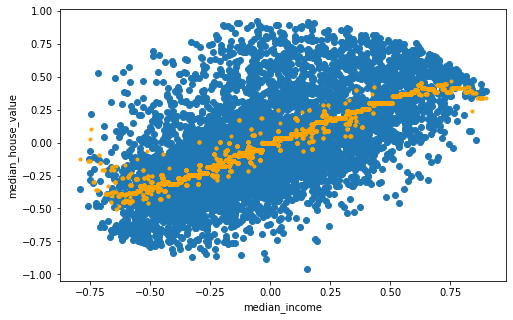

In [29]:
plt.figure(figsize=(8,5))
plt.plot(X_test,y_test,'o')
plt.xlabel("median_income")
plt.ylabel("median_house_value")
plt.plot(X_test,preds_prob,'.',c='orange')
plt.show()


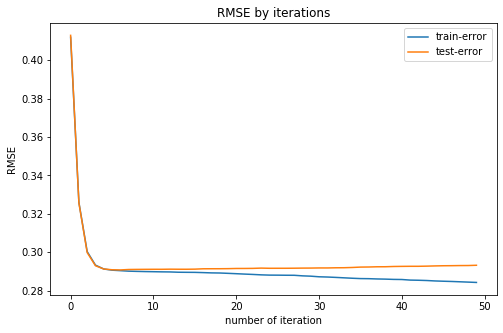

In [21]:
plt.figure(figsize=(8,5))
plt.plot(range(0,50),pd.DataFrame(ev['train']), label = "train-error")
plt.plot(range(0,50),pd.DataFrame(ev['test']), label = "test-error")
plt.xlabel("number of iteration")
plt.ylabel("RMSE")
plt.title("RMSE by iterations")
plt.legend()
plt.show()

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn import  tree, linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print(regr.predict(X_test))
regr.score(X_test,y_test)

[ 0.1163735  -0.26672251 -0.20059032 ...  0.1923344  -0.2241731
  0.22168837]


0.3776521472822447

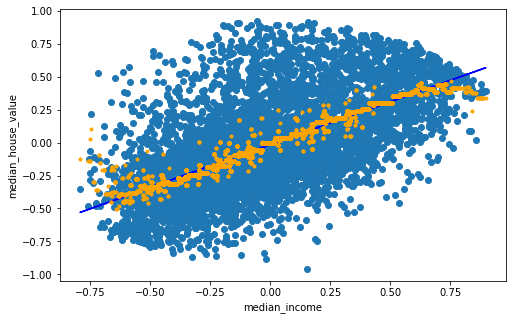

In [26]:
plt.figure(figsize=(8,5))
plt.plot(X_test,y_test,'o')
plt.xlabel("median_income")
plt.ylabel("median_house_value")
plt.plot(X_test,regr.predict(X_test),'b',c='blue')
plt.plot(X_test,preds_prob,'.',c='orange')
plt.show()


Здесь синие точки -- это реальные значения признаков, оранжевые -- boosting-предсказание признака median_house_value по признаку median_incomeб синяяя линия -- линейная регрессия. Просто картинка, чтобы посмотреть, как выглядят предсказания по бустингу.

<h2> Классификация</h2>

In [4]:
heart=pd.read_csv('heart.csv')
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Данные очень небольшого объема: 303. Диагностируем заболевание сердца.

Разобъем на тренировочную и тестовую выборки:

In [5]:
X = heart[heart.columns[heart.columns != 'target']]
y = heart.target
x_train, x_test, y_train, y_test = train_test_split(X, heart.target, test_size=0.33,random_state=2)

<h3> Градиентный бустинг

Запустим для начала просто с параметрами по умолчанию:

In [36]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [37]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)
score=cross_val_score(model,x_train,y_train,scoring='accuracy',cv=5)
print('CV-accuracy: ',statistics.mean(score))

CV-accuracy:  0.7737804878048781


In [38]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
conf_mat = metrics.confusion_matrix(y_test, predictions)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
print(conf_mat)
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))


    0   1
0  32  11
1   4  53
Test Accuracy: 85.00%


Accuracy на тесте больше, чем по кросс-валидации. Везение.

То же самое через xgb.train (иногда удобнее использовать его напрямую):

In [39]:
dtrain_h = xgb.DMatrix(x_train, y_train)
dtest_h = xgb.DMatrix(x_test, y_test)
params_h = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1
}
num_rounds = 50
xgb_model_h = xgb.train(params_h, dtrain_h, num_rounds)
preds_prob_h = xgb_model_h.predict(dtest_h)
predictions = [round(value) for value in preds_prob_h]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 85.00%


c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Попробуем подобрать параметры и улучшить результат. 

In [40]:
n_trees=[1]+list(range(10,105,2))
scoring=[]
for n_tree in n_trees:
    #estimator=xgb.XGBClassifier(n_estimators=n_tree,max_depth =3, learning_rate=0.1,
                            # objective='binary:logistic',
                             # booster='gbtree',random_state=1)
    #estimator.fit(x_train, y_train)
    estimator=xgb.XGBClassifier(n_estimators=n_tree,max_depth =3, learning_rate=0.1)
    score=cross_val_score(estimator,x_train,y_train,scoring='accuracy',cv=3)
    scoring.append(score)
scoring=np.asmatrix(scoring)
   

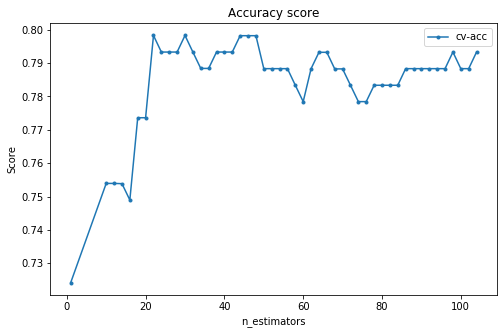

In [42]:
plt.figure(figsize=(8,5))
plt.plot(n_trees,scoring.mean(axis=1), label = "cv-acc",marker='.')
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Accuracy score")
plt.legend()
plt.show()

<h4>С набором случайных разбиений на test-train:</h4>

Так как объем выборки очень маленький, нельзя особо полагаться на результат, который показывает метод на тестовой выборке. Поэтому рассмотрим K разбиений на тренировочную и тестовую выборку, подберем параметры для каждой из них (в силу небольшого объема выборки параметры подбираем нежадно) и возьмем среднюю ошибку.

In [51]:
import statistics 
num_rounds = 30
K=10
accuracy_general=[]
for i in range(1,K,1):
    X_train, X_test, y_train, y_test = train_test_split(X, heart.target, test_size=0.33,random_state=i)
    dtrain_h = xgb.DMatrix(X_train, y_train)
    dtest_h = xgb.DMatrix(X_test, y_test)
    params_h = {
        'objective':['binary:logistic'],
        'learning_rate':[i/100.0 for i in range(1,25,5)],
         'max_depth':[1,2,3],
         'reg_alpha':[1e-2, 0.1, 1],
         'reg_lambda':[1e-2, 0.1, 1],
         'min_child_weight':range(1,6,1),
         'gamma':[i/10.0 for i in range(0,5)],
         'subsample':[i/10.0 for i in range(6,12,2)]
    }
    gsearch_h = GridSearchCV(xgb.XGBClassifier(n_estimators=30),
                        param_grid = params_h,n_jobs=4,iid=False, cv=3, scoring='roc_auc')
    gsearch_h.fit(X_train,y_train)
    best_parameters=gsearch_h.best_params_
    xgb_model=xgb.train(best_parameters,dtrain_h, num_rounds)
    preds_prob_h = xgb_model.predict(dtest_h)
    predictions = [round(value) for value in preds_prob_h]
    accuracy = accuracy_score(y_test, predictions)
    accuracy_general.append(accuracy)
print(statistics.mean(accuracy_general))
    

c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.8200000000000001


Так как с Randomforest сравнение уже проводили для регрессии, тут ограничимся сравнением ошибки на кросс-валидации этих методов с параметрами по умолчанию.

In [52]:
X = heart[heart.columns[heart.columns != 'target']]
y = heart.target
x_train, x_test, y_train, y_test = train_test_split(X, heart.target, test_size=0.33,random_state=2)
dtrain=xgb.DMatrix(x_train, y_train)
num_rounds = 100
params = {
    'objective':'binary:logistic',
    'learning_rate':0.1,
    'max_depth':2
}
hist = xgb.cv(params, dtrain, num_rounds, nfold=10, metrics={'error'}, seed=42)
print('CV-error XGBoost: ',statistics.mean(hist['test-error-mean']))
#print(metrics.classification_report(y_test, y_pred_test))

c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


CV-error XGBoost:  0.215585648


 Random Forest можно записать через бустинг так, например:

In [53]:
params_RF={
    'colsample_bynode': 0.8,
    'learning_rate': 1,
    'max_depth': 5,
    'num_parallel_tree': 100,
    'objective': 'binary:logistic',
    'subsample': 0.8,
    'tree_method': 'hist'   
}
hist_RF = xgb.cv(params_RF, dtrain, num_rounds, nfold=10, metrics={'error'}, seed=42)
print('CV-error RandomForest: ',statistics.mean(hist_RF['test-error-mean']))

CV-error RandomForest:  0.220857069


<h3>Adabust</h3>

В sklearn доступны алгоритмы AdaBoost и GradientBoosting для задач классификации и регрессии. Они более медленные, чем методы пакета XGBoost и менее гибкие (но иногда их проще применять).

In [6]:
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(
    DecisionTreeClassifier()
)

In [7]:
classifier.fit(x_train, y_train)
score=cross_val_score(classifier,x_train,y_train,scoring='accuracy',cv=10)
print('CV-error Adaboost', 1-statistics.mean(score))

CV-error Adaboost 0.30048872180451125
